## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi
import CMS_lumi, tdrstyle

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = 'v5'
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA

data_path = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+vers+'/'
lumi = 23.02*1000

if data_year == 2022:
    fpath['data'] = data_path + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    
for k, T in tree.items():
    branch_names = T.keys()

In [3]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

#cut_based = True
#cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpreadWeighted = {}
cscClusterTimeWeighted = {}
cscClusterTimeWeighted2 = {}
cscClusterTimeWeighted3 = {}

cscClusterNStation = {}
cscClusterDphi = {}
nCscClusters = {}

#Study trigger categories:
cscClusterTimeWeightedTr1 = {}
cscClusterTimeWeightedTr2 = {}
cscClusterTimeWeightedTr3 = {}
cscClusterEtaTr1 = {}
cscClusterEtaTr2 = {}
cscClusterEtaTr3 = {}
cscClusterNStationTr1 = {}
cscClusterNStationTr2 = {}
cscClusterNStationTr3 = {}
cscClusterSizeTr1 = {}
cscClusterSizeTr2 = {}
cscClusterSizeTr3 = {}

#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
nDtClusters = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p4 = {}
dtCluster_match_MB1hits_0p5 = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}


## Settings

In [4]:
category = 0#-1#0
category = 2
#-1: at least 1csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt, 

do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True

plot_string = ""
#plot_string = "_jet_veto"
#plot_string = "_csc_time_spread_cut"
#plot_string = "_csc_in_time_cut"
#plot_string = ""
#plot_string = "_ME_veto"
#plot_string = "_ME_veto_HLT_eta_cut"
#plot_string = "_ME_veto_HLT_eta_cut_at_least_1_cluster"
#plot_string = "_ME_veto_HLT_eta_cut_in_time_cut_at_least_1_cluster"
#plot_string+= "_exactly_1_csc_cluster"

#plot_string+= "_exactly_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_veto"
plot_string+= "_csc_dt_cluster_ME_MB_veto"

In [5]:
for a in branch_names:
    #if "MB1" in str(a):
    #    print(a)
    if "Station" in str(a):
        print(a)

b'cscRechitClusterNStation10'
b'cscRechitClusterAvgStation10'
b'cscRechitClusterMaxStation'
b'cscRechitClusterMaxStationRatio'
b'dtRechitClusterNSegStation1'
b'dtRechitClusterNSegStation2'
b'dtRechitClusterNSegStation3'
b'dtRechitClusterNSegStation4'
b'dtRechitClusterNOppositeSegStation1'
b'dtRechitClusterNOppositeSegStation2'
b'dtRechitClusterNOppositeSegStation3'
b'dtRechitClusterNOppositeSegStation4'
b'dtRechitClusterNoiseHitStation1'
b'dtRechitClusterNoiseHitStation2'
b'dtRechitClusterNoiseHitStation3'
b'dtRechitClusterNoiseHitStation4'
b'dtRechitClusterNStation10'
b'dtRechitClusterAvgStation10'
b'dtRechitClusterMaxStation'
b'dtRechitClusterMaxStationRatio'
b'dtRechitClusterNHitStation1'
b'dtRechitClusterNHitStation2'
b'dtRechitClusterNHitStation3'
b'dtRechitClusterNHitStation4'


In [6]:
for k, T in tree.items():
    tree_keys.append(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
########### SELECTION: CLUSTERS ############
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_csccluster = jet_veto_csc
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_not(jet_veto_csc)       

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    
        

    
    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))

    #ME11 and ME12 veto
    ME11_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )      

    
    
    
    
    #Try to understand if some categories have a different resolution in time
    #Trigger cat1
    sel_trgCluster_tr1 = np.logical_and( T.array('cscRechitClusterSize') >= 100, np.logical_and(T.array('cscRechitClusterNStation10')>=2, np.abs(T.array('cscRechitClusterEta'))<1.9))
    #Trigger cat2
    sel_trgCluster_tr2 = np.logical_and( T.array('cscRechitClusterSize') >= 200, np.logical_and(T.array('cscRechitClusterNStation10')==1, np.abs(T.array('cscRechitClusterEta'))<1.9))
    #Trigger cat3    
    sel_trgCluster_tr3 = np.logical_and( T.array('cscRechitClusterSize') >= 500, np.abs(T.array('cscRechitClusterEta'))>=1.9)
    
    sel_trgCluster = np.logical_and( T.array('cscRechitClusterSize') >= 100, np.logical_and(T.array('cscRechitClusterNStation10')>=2, np.abs(T.array('cscRechitClusterEta'))<1.9))
    sel_trgCluster =np.logical_or(sel_trgCluster, np.logical_and( T.array('cscRechitClusterSize') >= 200, np.logical_and(T.array('cscRechitClusterNStation10')==1, np.abs(T.array('cscRechitClusterEta'))<1.9)))
    sel_trgCluster =np.logical_or(sel_trgCluster, np.logical_and( T.array('cscRechitClusterSize') >= 500, np.abs(T.array('cscRechitClusterEta'))>=1.9))
    
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto,ME12_veto)
                                   ) 
    if do_HLT_eta_cut:
        sel_csccluster = np.logical_and(sel_csccluster,sel_trgCluster)

        
        
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    MB1_veto = T.array('dtRechitClusterNHitStation1') == 0
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto)
        
    #Check with Christina:
    '''
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    cut = 5
    station = (T.array('dtRechitClusterNSegStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4))
    '''
    
    #print(max_station)
    #print(sel_dtcluster)
    
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    #HLT_CaloMET60_DTCluster50 = hlt[:,562]
    #HLT_CaloMET60_DTClusterNoMB1S50 = hlt[:,563]
    #HLT_L1MET_DTCluster50 = hlt[:,564]
    #HLT_L1MET_DTClusterNoMB1S50 = hlt[:,565]
    HLT_CscCluster_Loose = hlt[:,566]
    HLT_CscCluster_Medium = hlt[:,567]
    HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

    #Or of the triggers: starting with the CSC ones
    #hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose,np.logical_or(HLT_CscCluster_Medium,HLT_CscCluster_Tight))
    if category==2:
        hlt_sel_ev[k] = HLT_L1CSCShower_DTCluster50
    else:
        hlt_sel_ev[k] = HLT_CscCluster_Loose

    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    #sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') > 200)
    sel_ev[k] = T.array('nLeptons') == 0
    
    #If trigger:
    #We don't have correct trigger emulation in signal at the moment
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)
    
    ##print("Events passing so far: ", sel_ev[k].sum())
    #sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    #sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    ##print("Events passing so far: ", sel_ev[k].sum())
    



    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
        #Adding this to avoid overlaps as a starting point
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 0)
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 2)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])       
    #break
########### BRANCHES ############
    ##### event variables #####
    #gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]

    if category == 0 or category==-1 or category==1:
        cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterTimeSpreadWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
        #cscRechitClusterDphi1[k] =  T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_csccluster][sel_ev[k]][:,:]
        #cscRechitClusterMe11Ratio[k] =  T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')[sel_csccluster][sel_ev[k]]  
        cscClusterSize2[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 1)  ][:,:]
        cscClusterTimeWeighted2[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 1)  ][:,:]
        cscClusterEta2[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 1)  ][:,:]
        
        cscClusterSize3[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 2)  ][:,:]
        cscClusterTimeWeighted3[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 2)  ][:,:]
        cscClusterEta3[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 2)  ][:,:]

        cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
        nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
        nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]

        
        sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        
        #Separate in trigger categories
        cscClusterTimeWeightedTr1[k] = T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[np.logical_and(sel_csccluster,sel_trgCluster_tr1)][sel_ev[k]][:,:]
        cscClusterTimeWeightedTr2[k] = T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[np.logical_and(sel_csccluster,sel_trgCluster_tr2)][sel_ev[k]][:,:]
        cscClusterTimeWeightedTr3[k] = T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[np.logical_and(sel_csccluster,sel_trgCluster_tr3)][sel_ev[k]][:,:]
        cscClusterEtaTr1[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[np.logical_and(sel_csccluster,sel_trgCluster_tr1)][sel_ev[k]][:,:]
        cscClusterEtaTr2[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[np.logical_and(sel_csccluster,sel_trgCluster_tr2)][sel_ev[k]][:,:]
        cscClusterEtaTr3[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[np.logical_and(sel_csccluster,sel_trgCluster_tr3)][sel_ev[k]][:,:]
        cscClusterNStationTr1[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[np.logical_and(sel_csccluster,sel_trgCluster_tr1)][sel_ev[k]][:,:]
        cscClusterNStationTr2[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[np.logical_and(sel_csccluster,sel_trgCluster_tr2)][sel_ev[k]][:,:]
        cscClusterNStationTr3[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[np.logical_and(sel_csccluster,sel_trgCluster_tr3)][sel_ev[k]][:,:]
        cscClusterSizeTr1[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[np.logical_and(sel_csccluster,sel_trgCluster_tr1)][sel_ev[k]][:,:]
        cscClusterSizeTr2[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[np.logical_and(sel_csccluster,sel_trgCluster_tr2)][sel_ev[k]][:,:]
        cscClusterSizeTr3[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[np.logical_and(sel_csccluster,sel_trgCluster_tr3)][sel_ev[k]][:,:]

        hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
        sel_ev[k] = sel_ev[k][ sel_ev[k] ]        

    elif category == 2:
        dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterNHitStation1[k] = T.array('dtRechitClusterNHitStation1')[sel_dtcluster][sel_ev[k]][:,:]
        dtCluster_match_MB1hits_0p4[k] = T.array('dtRechitCluster_match_MB1hits_0p4')[sel_dtcluster][sel_ev[k]][:,:]
        dtCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[sel_dtcluster][sel_ev[k]][:,:]
        
        
        cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterTimeSpreadWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
        nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
        nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
        
        
        sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        
        sel_jetveto_dt[k] = jet_veto_dt[sel_dtcluster][sel_ev[k]][:,:]
        sel_muonveto_dt[k] = muon_veto_dt[sel_dtcluster][sel_ev[k]][:,:]        
        #This gives some errors...
        #nMe11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[sel_csccluster][sel_ev[k]][:,0]+T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[sel_csccluster][sel_ev[k]][:,0]

        #To be fixed, some issues with deltaPhi function
        #deltaRCluster[k] = deltaR(dtRechitClusterEta[k], dtRechitClusterPhi[k],cscRechitClusterEta[k], cscRechitClusterPhi[k])
        #deltaEta[k] = dtRechitClusterEta[k]-cscRechitClusterEta[k]

        dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]]
        
        hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
        sel_ev[k] = sel_ev[k][ sel_ev[k] ]

    #nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k]),where=(nDtClusters[k] != 0))
    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))
    #print(nClusterRatio[k])
    #print(cscClusterSize[k])
    #print(cscClusterNStation[k])
    #weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev[k]]
    #nDtSectors[k] = np.sum(np.reshape(T.array('nDTRechitsSector')>=3, (-1,4*5*12)), axis = 1)[sel_ev[k]]
    #nDtStations[k] = T.array('nDtStations25')[sel_ev[k]]
    #nDtWheels[k] = T.array('nDtWheels25')[sel_ev[k]]



In [7]:
for k in tree_keys:
    print(nCscClusters[k])
    print(nDtClusters[k])    
print(category)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
2


## General histograms

Compare dtRechitClusterNHitsStation1 and dtRechitCluster_match_MB1hits_0p4 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

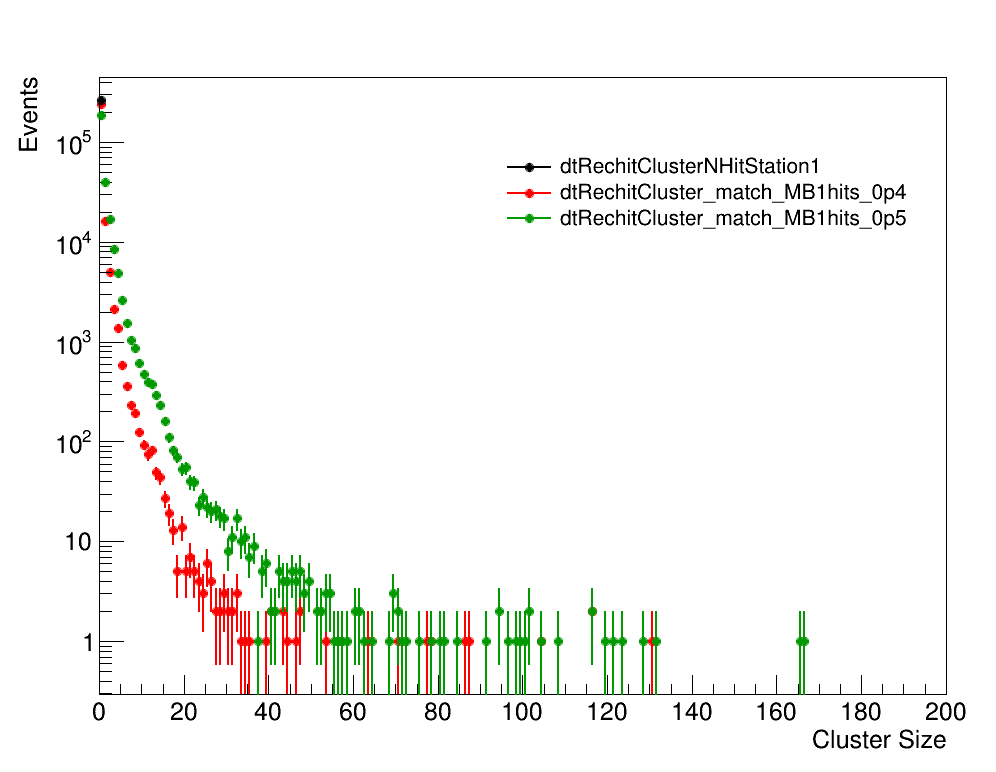

In [19]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.7,0.75,0.8)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    h0[k] = create_TH1D(dtClusterNHitStation1[k].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[200,0,200])
    leg.AddEntry(h0[k],"dtRechitClusterNHitStation1")
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(20)
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    h1[k] = create_TH1D(dtCluster_match_MB1hits_0p4[k].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[200,0,200])
    leg.AddEntry(h1[k],"dtRechitCluster_match_MB1hits_0p4")
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(20)
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    h2[k] = create_TH1D(dtCluster_match_MB1hits_0p5[k].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[200,0,200])
    leg.AddEntry(h2[k],"dtRechitCluster_match_MB1hits_0p5")
    h2[k].SetLineColor(418)
    h2[k].SetLineWidth(2)
    h2[k].SetMarkerColor(418)
    h2[k].SetMarkerStyle(20)
    h2[k].SetMarkerSize(1.2)
    
    h1[k].Draw('PE same')        
    h0[k].Draw('PE same')
    h2[k].Draw('PE same')

    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/DtClusterRecHitsStation1"+plot_string+".pdf")
can.Print("plots/V1p19_"+vers+"/DtClusterRecHitsStation1"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

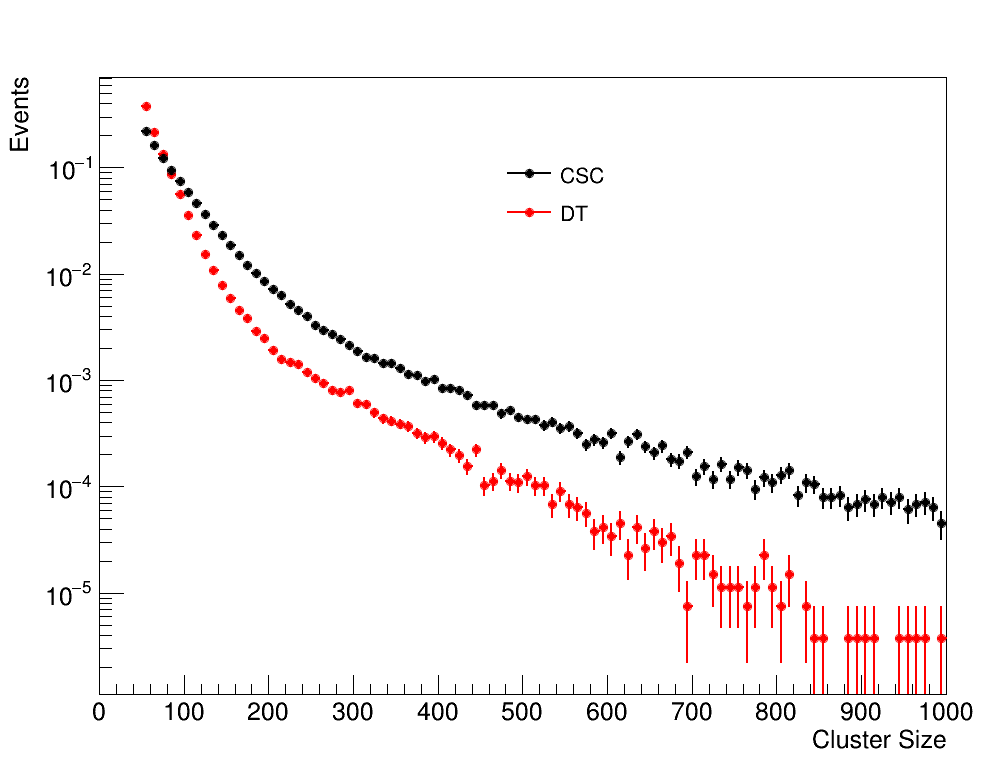

In [9]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.7,0.75,0.8)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    h0[k] = create_TH1D(cscClusterSize[k].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0[k],"CSC")
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(20)
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    h1[k] = create_TH1D(dtClusterSize[k].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1[k],"DT")
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(20)
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    h1[k].Draw('PE same')        
    h0[k].Draw('PE same')

    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CscDtClusterSize"+plot_string+".pdf")
can.Print("plots/V1p19_"+vers+"/CscDtClusterSize"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

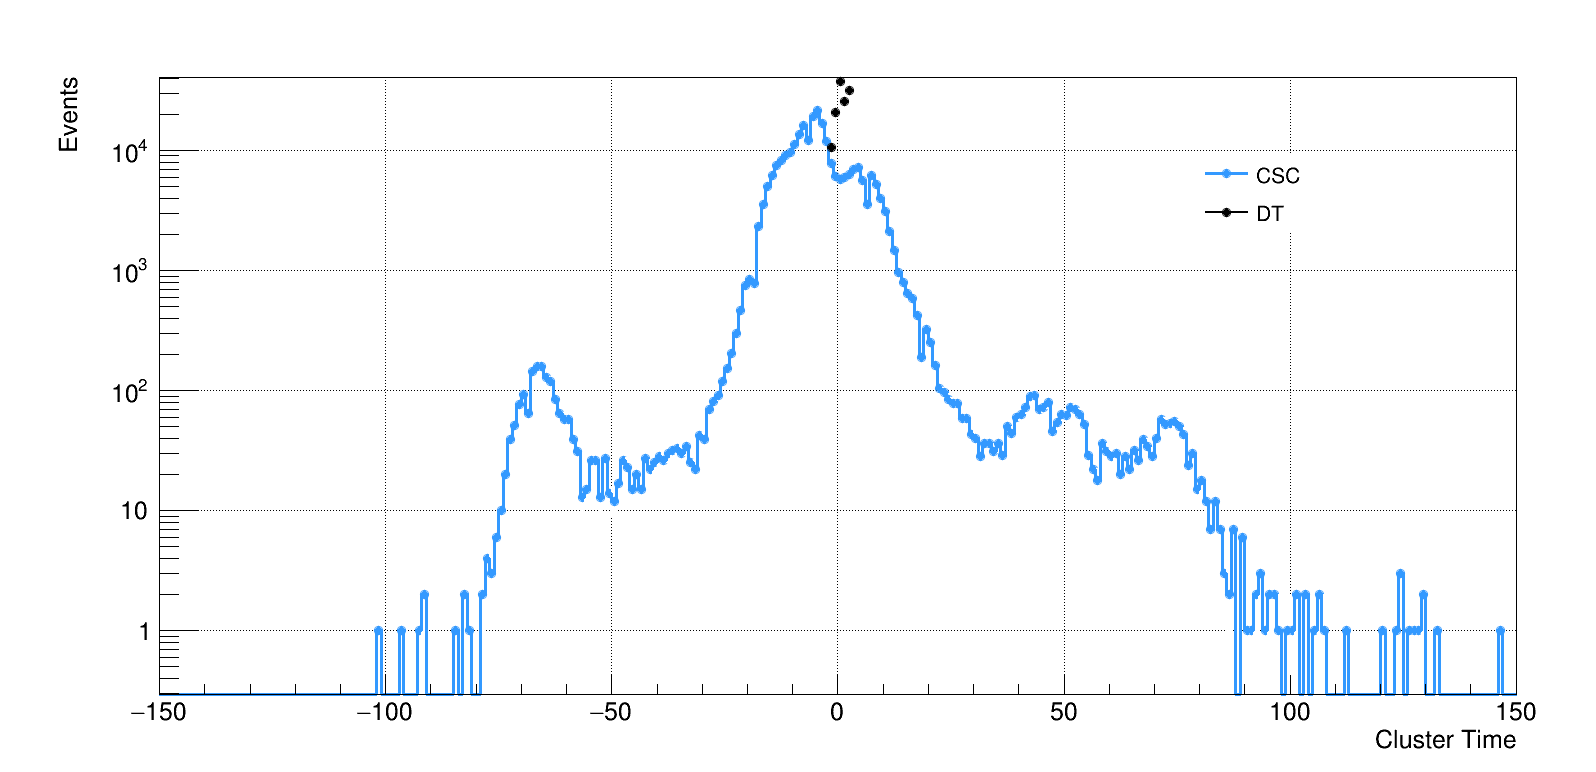

In [10]:
can = rt.TCanvas('c','c', 1600, 800)
leg = rt.TLegend(0.75,0.7,0.9,0.8)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:

    h[k] = create_TH1D(cscClusterTimeWeighted[k].flatten(),title="",axis_title = ['Cluster Time','Events'], binning=[300,-150,150])#binning=[100,-80,80])
    leg.AddEntry(h[k],"CSC")
    h[k].SetLineColor(861)
    h[k].SetLineWidth(3)
    h[k].SetMarkerColor(861)
    h[k].SetMarkerStyle(20)
    h[k].SetMarkerSize(1.2)
    #if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)    
    
    h0[k] = create_TH1D(dtClusterTime[k].flatten(),title="",axis_title = ['Cluster Time','Events'], binning=[300,-150,150])#binning=[100,-80,80])
    leg.AddEntry(h0[k],"DT")
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(20)
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

  
    h[k].Draw('histo E2 same')
    h0[k].Draw('PE same') 
    #h1[k].Draw('PE same')
    #h2[k].Draw('PE same')    

 
leg.Draw()
can.SetRightMargin(0.05)
can.SetGrid()

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CscDtClusterTime"+plot_string+".pdf")
can.Print("plots/V1p19_"+vers+"/CscDtClusterTime"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

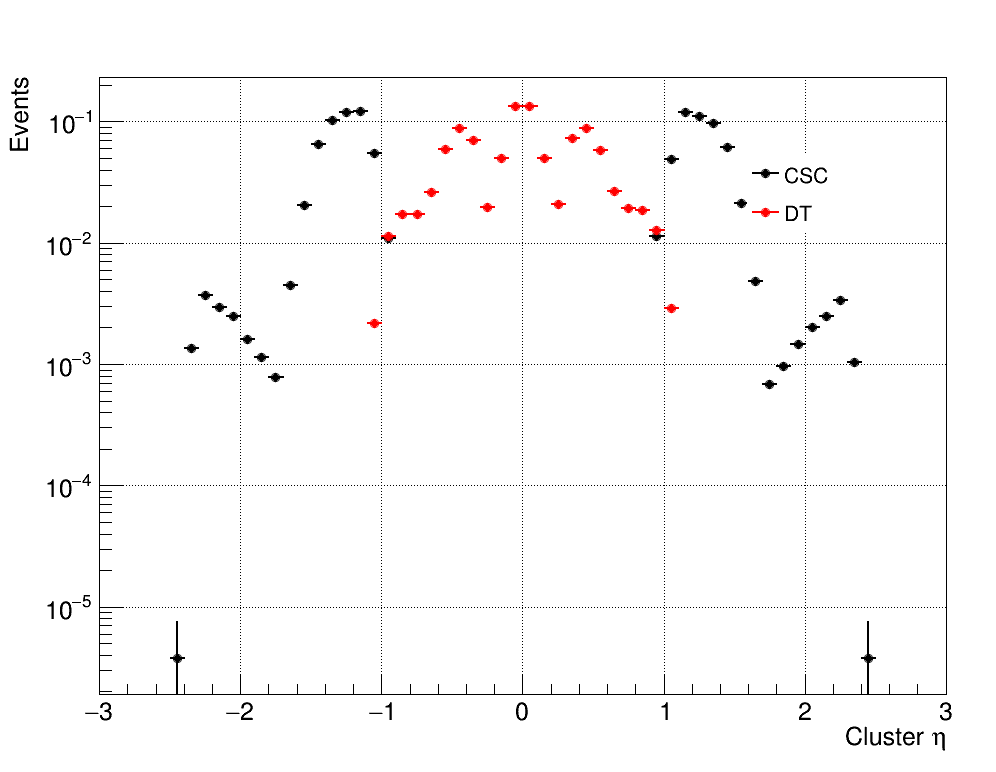

In [11]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.75,0.7,0.9,0.8)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    h0[k] = create_TH1D(cscClusterEta[k].flatten(),title="",axis_title = ['Cluster #eta','Events'], binning=[60,-3,3])
    leg.AddEntry(h0[k],"CSC")
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(20)
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    h1[k] = create_TH1D(dtClusterEta[k].flatten(),title="",axis_title = ['Cluster #eta','Events'], binning=[60,-3,3])
    leg.AddEntry(h1[k],"DT")
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(20)
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    
    h0[k].Draw('PE same') 
    h1[k].Draw('PE same')
    #h0[k].SetMinimum(1.e-4)
    
leg.Draw()
can.SetRightMargin(0.05)
can.SetGrid()

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CscDtClusterEta"+plot_string+".pdf")
can.Print("plots/V1p19_"+vers+"/CscDtClusterEta"+plot_string+".png")

# L1 and HLT plateau

In [12]:
L1_plateau = {}
HLT_plateau = {}

sel_trgCluster ={}

for k in tree_keys:
    sel_trgCluster[k] = ( dtClusterSize[k] >= 50)
    #Event level
    L1_plateau[k] = ((cscClusterSize[k] >= 200).any()==True)
    HLT_plateau[k] = sel_trgCluster[k].any()==True

    print(HLT_plateau[k].shape)
    print(sel_ev[k].shape)
    print(cscClusterSize[k].shape)

(263985,)
(263985,)
(263985,)


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

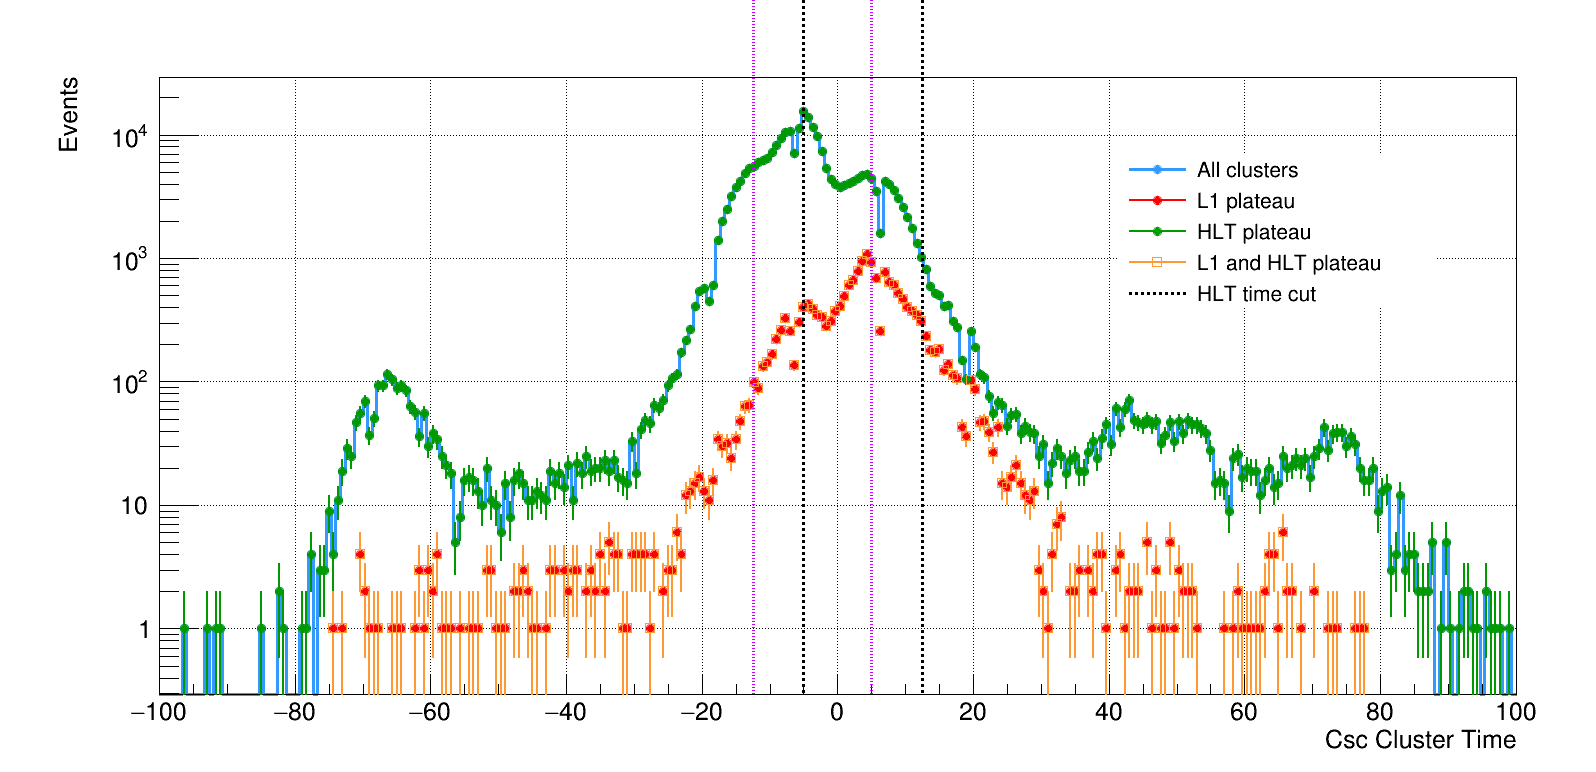

In [13]:
can = rt.TCanvas('c','c', 1600, 800)
leg = rt.TLegend(0.7,0.6,0.9,0.8)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
for k in tree_keys:

    h[k] = create_TH1D(cscClusterTimeWeighted[k].flatten(),title="",axis_title = ['Csc Cluster Time','Events'], binning=[300,-100,100])#binning=[100,-80,80])
    leg.AddEntry(h[k],"All clusters")
    h[k].SetLineColor(861)
    h[k].SetLineWidth(3)
    h[k].SetMarkerColor(861)
    h[k].SetMarkerStyle(20)
    h[k].SetMarkerSize(1.2)
    #if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)    

    
    h1[k] = create_TH1D(cscClusterTimeWeighted[k][ L1_plateau[k] ].flatten(),title="",axis_title = ['Csc Cluster Time','Events'], binning=[300,-100,100])#binning=[100,-80,80])#binning=[300,-150,150])
    leg.AddEntry(h1[k],"L1 plateau")
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(20)
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    h2[k] = create_TH1D(cscClusterTimeWeighted[k][HLT_plateau[k]].flatten(),title="",axis_title = ['Csc Cluster Time','Events'], binning=[300,-100,100])#binning=[100,-80,80])#
    leg.AddEntry(h2[k],"HLT plateau")
    h2[k].SetLineColor(418)
    h2[k].SetLineWidth(2)
    h2[k].SetMarkerColor(418)
    h2[k].SetMarkerStyle(20)
    h2[k].SetMarkerSize(1.2)
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())

    h3[k] = create_TH1D(cscClusterTimeWeighted[k][ np.logical_and(L1_plateau[k],HLT_plateau[k]) ].flatten(),title="",axis_title = ['Csc Cluster Time','Events'], binning=[300,-100,100])#binning=[100,-80,80])#
    leg.AddEntry(h3[k],"L1 and HLT plateau")
    h3[k].SetLineColor(801)
    h3[k].SetLineWidth(2)
    h3[k].SetMarkerColor(801)
    h3[k].SetMarkerStyle(25)
    h3[k].SetMarkerSize(1.2)
    #if h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())    
    
    h[k].Draw('histo E2 same')
    h1[k].Draw('PE same')
    h2[k].Draw('PE same')    
    h3[k].Draw('PE same')    

    line_neg = rt.TLine(-5,0.,-5,1e6)
    line_neg.SetLineWidth(3)
    line_neg.SetLineStyle(2)
    line_neg.Draw('same')

    line_pos = rt.TLine(12.5,0.,12.5,1e6)
    line_pos.SetLineWidth(3)
    line_pos.SetLineStyle(2)
    line_pos.Draw('same')    

    leg.AddEntry(line_pos,"HLT time cut","L")
    
    line_neg2 = rt.TLine(-12.5,0.,-12.5,1e6)
    line_neg2.SetLineWidth(3)
    line_neg2.SetLineStyle(3)
    line_neg2.SetLineColor(880)
    line_neg2.Draw('same')

    line_pos2 = rt.TLine(5,0.,5,1e6)
    line_pos2.SetLineWidth(3)
    line_pos2.SetLineStyle(3)
    line_pos2.SetLineColor(880)
    line_pos2.Draw('same')     
    
leg.Draw()
can.SetRightMargin(0.05)
can.SetGrid()

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CscClusterTime_compare_L1_HLT_plateau"+plot_string+".pdf")
can.Print("plots/V1p19_"+vers+"/CscClusterTime_compare_L1_HLT_plateau"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

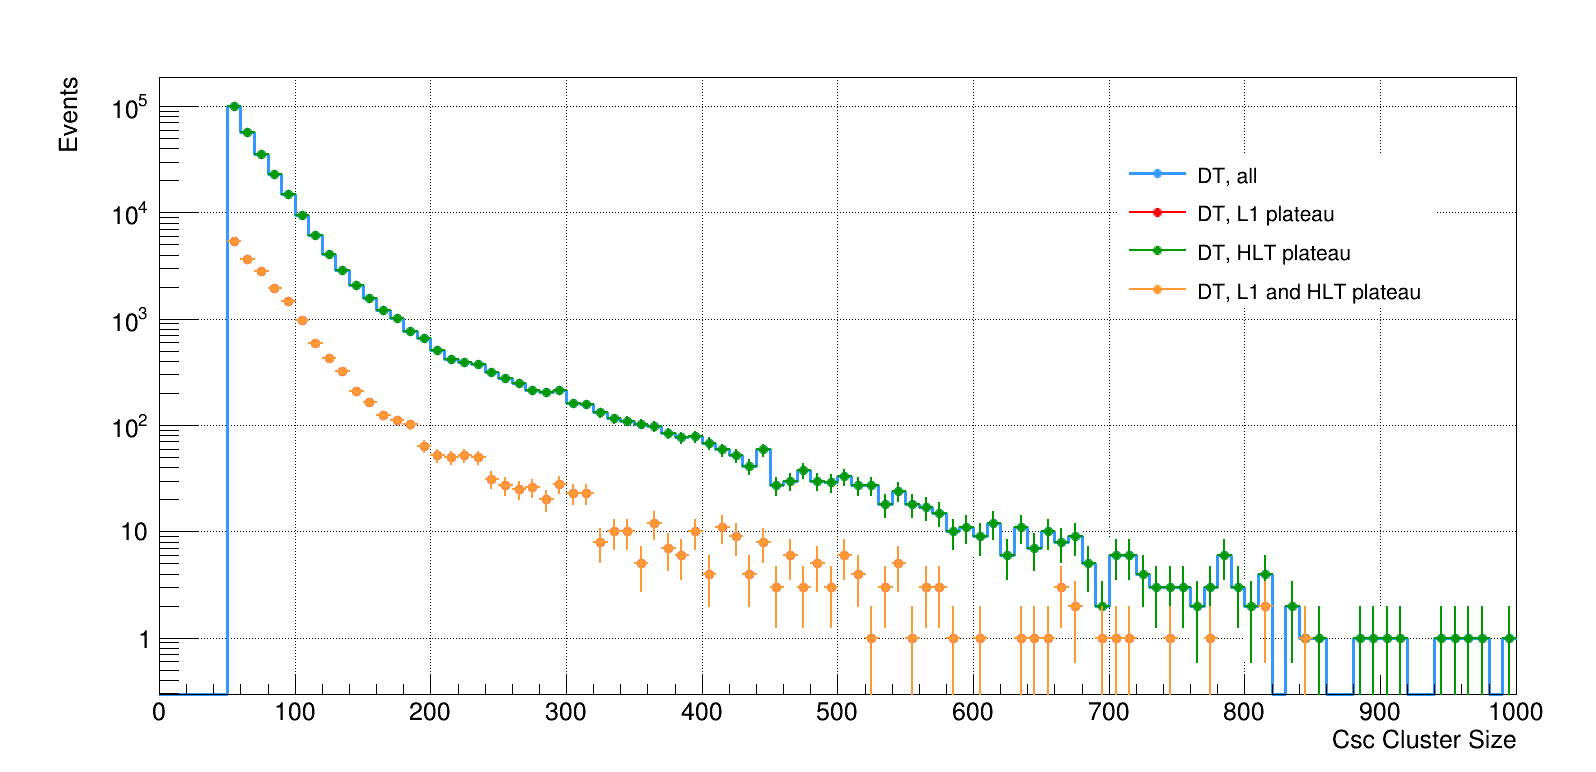

In [14]:
can = rt.TCanvas('c','c', 1600, 800)
leg = rt.TLegend(0.7,0.6,0.9,0.8)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
for k in tree_keys:

    h[k] = create_TH1D(dtClusterSize[k].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h[k],"DT, all")
    h[k].SetLineColor(861)
    h[k].SetLineWidth(3)
    h[k].SetMarkerColor(861)
    h[k].SetMarkerStyle(20)
    h[k].SetMarkerSize(1.2)
    #if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)    

    
    h1[k] = create_TH1D(dtClusterSize[k][ L1_plateau[k] ].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1[k],"DT, L1 plateau")
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(20)
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    h2[k] = create_TH1D(dtClusterSize[k][HLT_plateau[k]].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h2[k],"DT, HLT plateau")
    h2[k].SetLineColor(418)
    h2[k].SetLineWidth(2)
    h2[k].SetMarkerColor(418)
    h2[k].SetMarkerStyle(20)
    h2[k].SetMarkerSize(1.2)
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())

    h3[k] = create_TH1D(dtClusterSize[k][ np.logical_and(L1_plateau[k],HLT_plateau[k]) ].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h3[k],"DT, L1 and HLT plateau")
    h3[k].SetLineColor(801)
    h3[k].SetLineWidth(2)
    h3[k].SetMarkerColor(801)
    h3[k].SetMarkerStyle(20)
    h3[k].SetMarkerSize(1.2)
    #if h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())    
    
    h[k].Draw('histo E2 same')
    h1[k].Draw('PE same')
    h2[k].Draw('PE same')    
    h3[k].Draw('PE same')    

    line_neg = rt.TLine(-5,0.,-5,1e6)
    line_neg.SetLineWidth(3)
    line_neg.SetLineStyle(2)
    #line_neg.Draw('same')

    line_pos = rt.TLine(12.5,0.,12.5,1e6)
    line_pos.SetLineWidth(3)
    line_pos.SetLineStyle(2)
    #line_pos.Draw('same')    

    #leg.AddEntry(line_pos,"HLT time cut","L")
       
    
leg.Draw()
can.SetRightMargin(0.05)
can.SetGrid()

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CscDtClusterSize_compare_L1_HLT_plateau"+plot_string+".pdf")
can.Print("plots/V1p19_"+vers+"/CscDtClusterSize_compare_L1_HLT_plateau"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

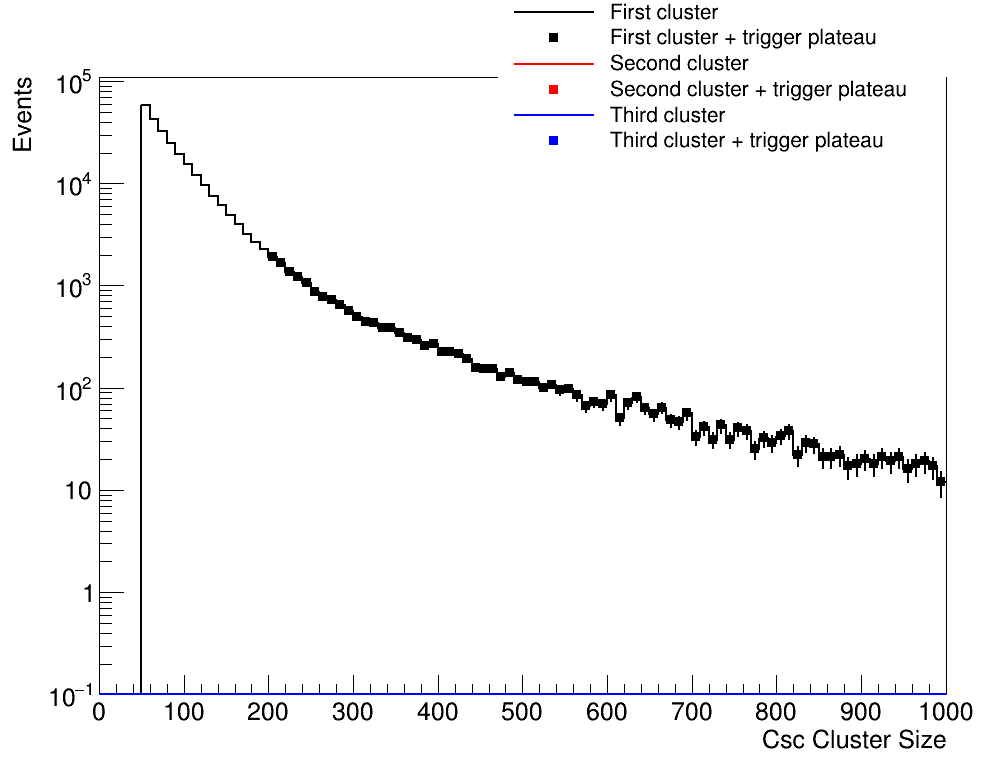

In [15]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.8,0.95,1.)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h0T = {}
h1T = {}
h2T = {}
can.cd()
norm = False
for k in tree_keys:
    h0[k] = create_TH1D(cscClusterSize[k][:,0].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0[k],"First cluster","L")
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(24)
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0 and norm:h0[k].Scale(1./h0[k].Integral())
        
    h0T[k] = create_TH1D(cscClusterSize[k][ np.logical_and(L1_plateau[k],HLT_plateau[k]) ][:,0].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0T[k],"First cluster + trigger plateau","P")
    h0T[k].SetLineColor(1)
    h0T[k].SetLineWidth(2)
    h0T[k].SetMarkerColor(1)
    h0T[k].SetMarkerStyle(21)
    h0T[k].SetMarkerSize(1.2)
    if h0T[k].Integral()>0 and norm:h0T[k].Scale(1./h0T[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    h1[k] = create_TH1D(cscClusterSize[k][ nCscClusters[k]>1 ][:,1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1[k],"Second cluster","L")
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(24)
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0 and norm:h1[k].Scale(1./h1[k].Integral())
    
    h1T[k] = create_TH1D(cscClusterSize[k][ np.logical_and(np.logical_and(L1_plateau[k],HLT_plateau[k]),nCscClusters[k]>1) ][:,1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1T[k],"Second cluster + trigger plateau","P")
    h1T[k].SetLineColor(2)
    h1T[k].SetLineWidth(2)
    h1T[k].SetMarkerColor(2)
    h1T[k].SetMarkerStyle(21)
    h1T[k].SetMarkerSize(1.2)
    if h1T[k].Integral()>0 and norm:h1T[k].Scale(1./h1T[k].Integral())    
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    
    h2[k] = create_TH1D(cscClusterSize[k][ nCscClusters[k]>2 ][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h2[k],"Third cluster","L")
    h2[k].SetLineColor(4)
    h2[k].SetLineWidth(2)
    h2[k].SetMarkerColor(4)
    h2[k].SetMarkerStyle(24)
    h2[k].SetMarkerSize(1.2)    
    if h2[k].Integral()>0 and norm:h2[k].Scale(1./h2[k].Integral())
    
    h2T[k] = create_TH1D(cscClusterSize[k][ np.logical_and(np.logical_and(L1_plateau[k],HLT_plateau[k]),nCscClusters[k]>2) ][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h2T[k],"Third cluster + trigger plateau","P")
    h2T[k].SetLineColor(4)
    h2T[k].SetLineWidth(2)
    h2T[k].SetMarkerColor(4)
    h2T[k].SetMarkerStyle(21)
    h2T[k].SetMarkerSize(1.2)    
    if h2T[k].Integral()>0 and norm:h2T[k].Scale(1./h2T[k].Integral())

        
    h0[k].Draw('HISTO same')
    h0[k].SetMinimum(0.1)
    h1[k].Draw('HISTO same')
    h2[k].Draw('HISTO same')   
    h1T[k].Draw('PE same')
    h0T[k].Draw('PE same')
    h2T[k].Draw('PE same')  
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CscClusterSize_L1_HLT_plateau"+plot_string+".pdf")
can.Print("plots/V1p19_"+vers+"/CscClusterSize_L1_HLT_plateau"+plot_string+".png")

# Todo list

* Look at different endcaps in the plot for csc time and n station
* Look at clusters associated with a muon, do they have the double peak?
* Look at clusters associated with a jet, double peak?
* Does the time spread cut remove the second peak?
* Study v4
* Study v5 --> some small amount of events with less than 50 hits in dbscan
* Study what happens with L1 and HLT conditions and more than 1 CSC cluster
* Study DT turn on